In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import ast
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import numba
import seaborn as sns
from statannotations.Annotator import Annotator
import iqplot
from sklearn import metrics
import bokeh.models
import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [5]:
df_s25_2 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO25beta.csv')
df_s25_4 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO25gnn.csv')
df_s50_2 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO50beta.csv')
df_s50_4 = pd.read_csv('data/SERGIO/SeedConsistancySERGIO50gnn.csv')
df25x = pd.read_csv('data/SERGIO/SERGIO25SubgraphXRandomSeed.csv')
df50x = pd.read_csv('data/SERGIO/SERGIO50SubgraphXRandomSeed.csv')
dfsubgraphx = pd.concat([df25x, df50x])
dfsubgraphx = dfsubgraphx.rename(columns={'Full Acc': 'Accuracy', 'Full Prec': 'Precision', 'Full Rec': 'Recall'})
frames = [df_s25_2, df_s25_4, df_s50_2, df_s50_4, dfsubgraphx]
df_sergio = pd.concat(frames)
df_sergio['Explainer'] = df_sergio['Explainer'].apply({'gnn':'GNN', 'beta':'Beta','GNN':'GNN','Beta':'Beta', 'SubgraphX': 'SubgraphX'}.get)
df_sergio['F1 Score'] = (2 * df_sergio['Torch Precision'] * df_sergio['Torch Recall']) / (df_sergio['Torch Precision'] + df_sergio['Torch Recall'])
df_sergio['Full F1 Score'] = (2 * df_sergio['Precision'] * df_sergio['Recall']) / (df_sergio['Precision'] + df_sergio['Recall'])
df_sergio = df_sergio.rename(columns={'Accuracy': 'Full Accuracy', 'Precision': 'Full Precision', 'Recall': 'Full Recall'})
df_sergio = df_sergio.rename(columns={'Torch Accuracy':'Accuracy','Torch Recall':
                                      'Recall','Torch Precision':'Precision', 'Faithfulness':'Unfaithfulness'})
df_sergio = df_sergio.fillna(0)
df_sergio['Dataset'] = df_sergio['Dataset'].apply({25:'25%', 50:'50%'}.get)

In [6]:
df_base2 = pd.read_csv('data/xAI/baseBetaExpxAISeedResults.csv')
df_base4 = pd.read_csv('data/xAI/baseGNNExpxAISeedResults.csv')
df_base2['Explainer'] = 'Beta'
df_base4['Explainer'] = 'GNN'
frames = [df_base2,df_base4]
df_base = pd.concat(frames)
df_base['Dataset'] = 'SG-BASE'
df_hetero2 = pd.read_csv('data/xAI/heteroBetaExpxAISeedResults.csv')
df_hetero4 = pd.read_csv('data/xAI/heteroGNNExpxAISeedResults.csv')
df_hetero2['Explainer'] = 'Beta'
df_hetero4['Explainer'] = 'GNN'
frames = [df_hetero2,df_hetero4]
df_hetero = pd.concat(frames)
df_hetero['Dataset'] = 'SG-HETEROPHILIC'
df_unfair2 = pd.read_csv('data/xAI/unfairBetaExpxAISeedResults.csv')
df_unfair4 = pd.read_csv('data/xAI/unfairGNNExpxAISeedResults.csv')
df_unfair2['Explainer'] = 'Beta'
df_unfair4['Explainer'] = 'GNN'
frames = [df_unfair2,df_unfair4]
df_unfair = pd.concat(frames)
df_unfair['Dataset'] = 'SG-UNFAIR'
df_less2 = pd.read_csv('data/xAI/lessinformBetaExpxAISeedResults.csv')
df_less4 = pd.read_csv('data/xAI/lessinformGNNExpxAISeedResults.csv')
df_less2['Explainer'] = 'Beta'
df_less4['Explainer'] = 'GNN'
frames = [df_less2,df_less4]
df_less = pd.concat(frames)
df_less['Dataset'] = 'SG-LESSINFORM'
df_more2 = pd.read_csv('data/xAI/moreinformBetaExpxAISeedResults.csv')
df_more4 = pd.read_csv('data/xAI/moreinformGNNExpxAISeedResults.csv')
df_more2['Explainer'] = 'Beta'
df_more4['Explainer'] = 'GNN'
frames = [df_more2,df_more4]
df_more = pd.concat(frames)
df_more['Dataset'] = 'SG-MOREINFORM'
frames = [df_base,df_hetero,df_unfair,df_less,df_more]
df_xai = pd.concat(frames)
df_xai = df_xai.rename(columns={'Best Acc':'Accuracy','Best Faith':'Unfaithfulness', 'Avg Faith':'Average Unfaithfulness'})
df_xai['F1 Score'] = (2 * df_xai['Best Prec'] * df_xai['Best Rec']) / (df_xai['Best Prec'] + df_xai['Best Rec'])
df1 = pd.read_csv('data/xAI SubgraphX/baseSeedResults.csv')
df1['Dataset'] = 'SG-BASE'
df2 = pd.read_csv('data/xAI SubgraphX/heteroSeedResults.csv')
df2['Dataset'] = 'SG-HETEROPHILIC'
df3 = pd.read_csv('data/xAI SubgraphX/unfairSeedResults.csv')
df3['Dataset'] = 'SG-UNFAIR'
df4 = pd.read_csv('data/xAI SubgraphX/lessinformSeedResults.csv')
df4['Dataset'] = 'SG-LESSINFORM'
df5 = pd.read_csv('data/xAI SubgraphX/moreinformSeedResults.csv')
df5['Dataset'] = 'SG-MOREINFORM'
subgraphx = pd.concat([df1,df2,df3,df4,df5])
subgraphx['Explainer'] = 'SubgraphX'
df_xai = pd.concat([df_xai, subgraphx])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50%_GNN vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.228e-03 U_stat=9.000e+01
25%_Beta vs. 25%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.543e-02 U_stat=2.650e+01
25%_GNN vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:4.423e-01 U_stat=4.000e+01
25%_Beta vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=1.000e+02


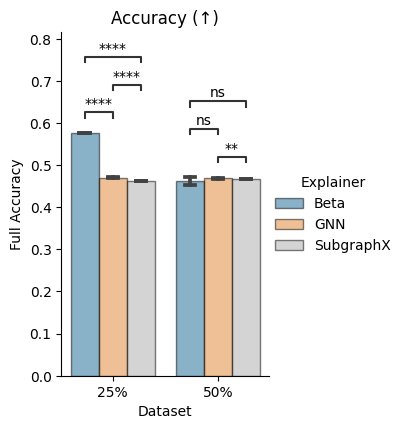

In [7]:
x = 'Dataset'
y = 'Full Accuracy'
hue = 'Explainer'
hue_order = ['Beta','GNN','SubgraphX']
order = ['25%', '50%']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='Accuracy (↑)')
pairs = [
    (("25%", "Beta"), ("25%", "GNN")),
    (("50%", "Beta"), ("50%", "GNN")),
    (("25%", "Beta"), ("25%", "SubgraphX")),
    (("50%", "Beta"), ("50%", "SubgraphX")),
    (("25%", "SubgraphX"), ("25%", "GNN")),
    (("50%", "SubgraphX"), ("50%", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/SERGIOAcc.png", bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50%_GNN vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:6.626e-04 U_stat=9.000e+01
25%_Beta vs. 25%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=8.200e+01
25%_GNN vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:7.512e-04 U_stat=9.000e+01
25%_Beta vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=1.000e+02


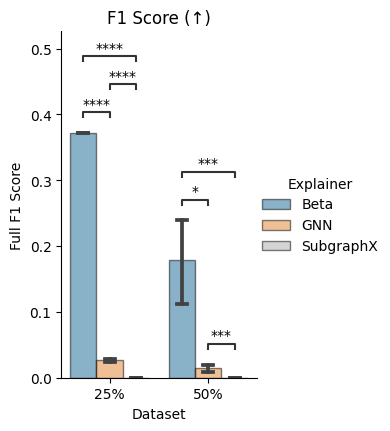

In [8]:
x = 'Dataset'
y = 'Full F1 Score'
hue = 'Explainer'
hue_order = ['Beta','GNN','SubgraphX']
order = ['25%', '50%']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='F1 Score (↑)')
pairs = [
    (("25%", "Beta"), ("25%", "GNN")),
    (("50%", "Beta"), ("50%", "GNN")),
    (("25%", "Beta"), ("25%", "SubgraphX")),
    (("50%", "Beta"), ("50%", "SubgraphX")),
    (("25%", "SubgraphX"), ("25%", "GNN")),
    (("50%", "SubgraphX"), ("50%", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/SERGIOF1.png", bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50%_GNN vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_Beta vs. 25%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=0.000e+00
50%_Beta vs. 50%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_GNN vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
50%_Beta vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_Beta vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=0.000e+00


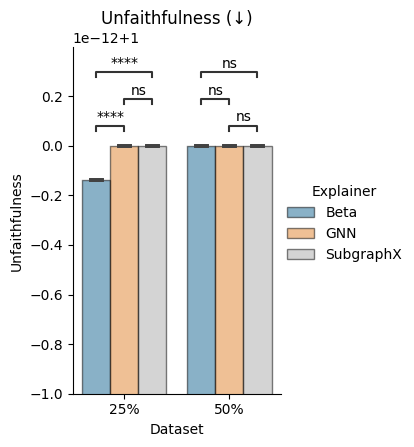

In [9]:
x = 'Dataset'
y = 'Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN','SubgraphX']
order = ['25%', '50%']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='Unfaithfulness (↓)')
pairs = [
    (("25%", "Beta"), ("25%", "GNN")),
    (("50%", "Beta"), ("50%", "GNN")),
    (("25%", "Beta"), ("25%", "SubgraphX")),
    (("50%", "Beta"), ("50%", "SubgraphX")),
    (("25%", "SubgraphX"), ("25%", "GNN")),
    (("50%", "SubgraphX"), ("50%", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        ax.set_ylim(0.999999999999, 1)
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/SERGIOUnfaith.png", bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50%_GNN vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_Beta vs. 25%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=0.000e+00
50%_Beta vs. 50%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_GNN vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
50%_Beta vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_Beta vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=0.000e+00


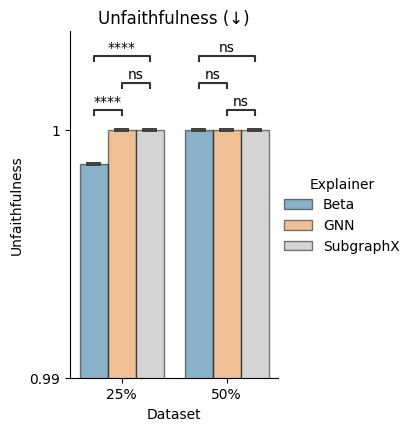

In [10]:
x = 'Dataset'
y = 'Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN','SubgraphX']
order = ['25%', '50%']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='Unfaithfulness (↓)')
pairs = [
    (("25%", "Beta"), ("25%", "GNN")),
    (("50%", "Beta"), ("50%", "GNN")),
    (("25%", "Beta"), ("25%", "SubgraphX")),
    (("50%", "Beta"), ("50%", "SubgraphX")),
    (("25%", "SubgraphX"), ("25%", "GNN")),
    (("50%", "SubgraphX"), ("50%", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        ax.set_ylim(0.999999999999, 1)
        #ax.set_yticks([0.999999999998, 0.999999999999, 1], [0.999999999998, 0.999999999999, 1]) 
        ax.set_yticks([0.999999999999, 1], [0.99, 1]) 
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/SERGIOUnfaith.png", bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50%_GNN vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
25%_Beta vs. 25%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.543e-02 U_stat=2.650e+01
25%_GNN vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.704e-02 U_stat=2.000e+01
25%_Beta vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=1.000e+02


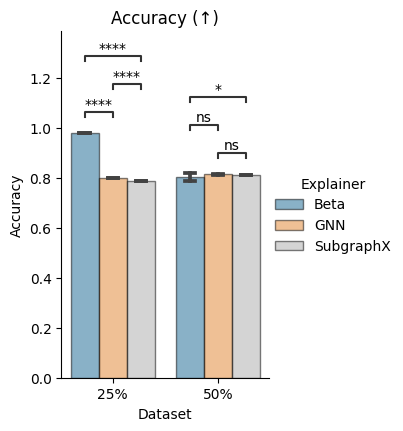

In [11]:
x = 'Dataset'
y = 'Accuracy'
hue = 'Explainer'
hue_order = ['Beta','GNN','SubgraphX']
order = ['25%', '50%']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='Accuracy (↑)')
pairs = [
    (("25%", "Beta"), ("25%", "GNN")),
    (("50%", "Beta"), ("50%", "GNN")),
    (("25%", "Beta"), ("25%", "SubgraphX")),
    (("50%", "Beta"), ("50%", "SubgraphX")),
    (("25%", "SubgraphX"), ("25%", "GNN")),
    (("50%", "SubgraphX"), ("50%", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
#g.figure.savefig('Vis/SERGIOAccMinus.png')  
plt.savefig("Vis/SERGIOAccMinus.png", bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

50%_GNN vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:6.626e-04 U_stat=9.000e+01
25%_Beta vs. 25%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=8.200e+01
25%_GNN vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.428e-05 U_stat=1.000e+02
50%_Beta vs. 50%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:7.512e-04 U_stat=9.000e+01
25%_Beta vs. 25%_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.594e-05 U_stat=1.000e+02


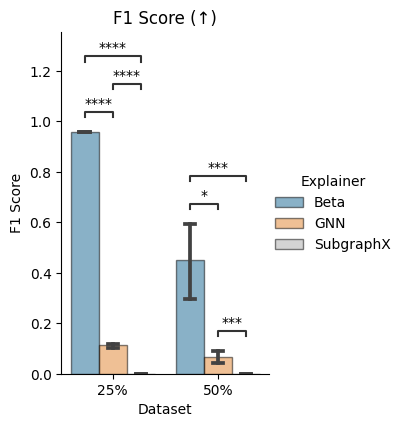

In [12]:
x = 'Dataset'
y = 'F1 Score'
hue = 'Explainer'
hue_order = ['Beta','GNN', 'SubgraphX']
order = ['25%', '50%']
args = dict(x=x, y=y, data=df_sergio, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='F1 Score (↑)')
pairs = [
    (("25%", "Beta"), ("25%", "GNN")),
    (("50%", "Beta"), ("50%", "GNN")),
    (("25%", "Beta"), ("25%", "SubgraphX")),
    (("50%", "Beta"), ("50%", "SubgraphX")),
    (("25%", "SubgraphX"), ("25%", "GNN")),
    (("50%", "SubgraphX"), ("50%", "GNN")),
]
for ax_n in g.axes:
    for ax in ax_n:
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
#g.figure.savefig('Vis/SERGIOF1Minus.png')  
plt.savefig("Vis/SERGIOF1Minus.png", bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_GNN vs. SG-HETEROPHILIC_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.024e-03 U_stat=5.300e+01
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.000e-01 U_stat=5.545e+02
SG-LESSINFORM_GNN vs. SG-LESSINFORM_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.260e-06 U_stat=0.000e+00
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-02 U_stat=6.605e+02
SG-MOREINFORM_GNN vs. SG-MOREINFORM_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:9.654e-06 U_stat=1.000e+01
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.051e-01 U_stat=5.400e+02
SG-UNFAIR_GNN vs. SG-UNFAIR_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.450e-03 U_stat=5.000e+01
SG-BASE_Beta vs. SG-

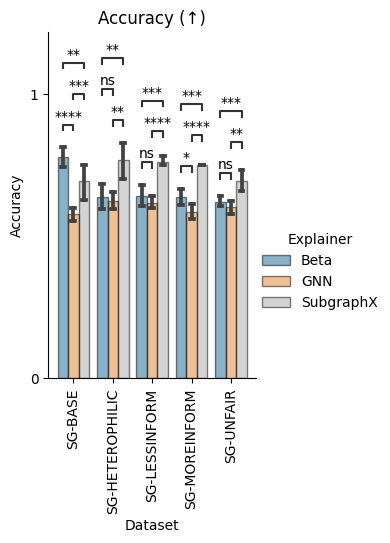

In [36]:
x = 'Dataset'
y = 'Accuracy'
hue = 'Explainer'
hue_order = ['Beta','GNN', 'SubgraphX']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='Accuracy (↑)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-BASE", "Beta"), ("SG-BASE", "SubgraphX")),
    (("SG-BASE", "GNN"), ("SG-BASE", "SubgraphX")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "SubgraphX")),
    (("SG-HETEROPHILIC", "GNN"), ("SG-HETEROPHILIC", "SubgraphX")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "SubgraphX")),
    (("SG-LESSINFORM", "GNN"), ("SG-LESSINFORM", "SubgraphX")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "SubgraphX")),
    (("SG-MOREINFORM", "GNN"), ("SG-MOREINFORM", "SubgraphX")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "SubgraphX")),
    (("SG-UNFAIR", "GNN"), ("SG-UNFAIR", "SubgraphX")),
]
for ax_n in g.axes:
    for ax in ax_n:
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 1], [0, 1]) 
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/xAIAcc.png", bbox_inches='tight')  

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_GNN vs. SG-HETEROPHILIC_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.024e-03 U_stat=5.300e+01
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.779e-01 U_stat=5.580e+02
SG-LESSINFORM_GNN vs. SG-LESSINFORM_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.316e-06 U_stat=0.000e+00
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.099e-02 U_stat=6.615e+02
SG-MOREINFORM_GNN vs. SG-MOREINFORM_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:9.689e-06 U_stat=1.000e+01
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.973e-01 U_stat=5.410e+02
SG-UNFAIR_GNN vs. SG-UNFAIR_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:1.648e-03 U_stat=5.100e+01
SG-BASE_Beta vs. SG-

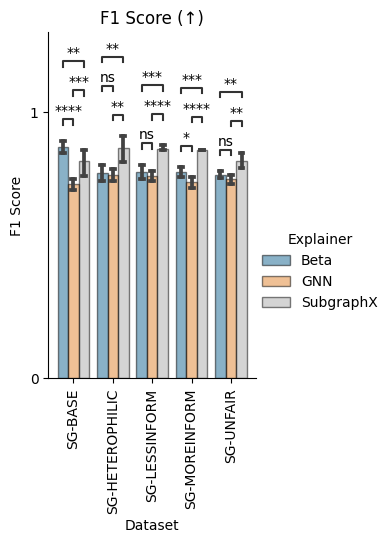

In [38]:
x = 'Dataset'
y = 'F1 Score'
hue = 'Explainer'
hue_order = ['Beta','GNN', 'SubgraphX']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='F1 Score (↑)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-BASE", "Beta"), ("SG-BASE", "SubgraphX")),
    (("SG-BASE", "GNN"), ("SG-BASE", "SubgraphX")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "SubgraphX")),
    (("SG-HETEROPHILIC", "GNN"), ("SG-HETEROPHILIC", "SubgraphX")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "SubgraphX")),
    (("SG-LESSINFORM", "GNN"), ("SG-LESSINFORM", "SubgraphX")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "SubgraphX")),
    (("SG-MOREINFORM", "GNN"), ("SG-MOREINFORM", "SubgraphX")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "SubgraphX")),
    (("SG-UNFAIR", "GNN"), ("SG-UNFAIR", "SubgraphX")),
]
for ax_n in g.axes:
    for ax in ax_n:
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 1], [0, 1]) 
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/xAIF1.png", bbox_inches='tight')  

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SG-HETEROPHILIC_GNN vs. SG-HETEROPHILIC_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.667e-06 U_stat=0.000e+00
SG-LESSINFORM_Beta vs. SG-LESSINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.872e-02 U_stat=3.400e+02
SG-LESSINFORM_GNN vs. SG-LESSINFORM_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:3.066e-01 U_stat=1.890e+02
SG-MOREINFORM_Beta vs. SG-MOREINFORM_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.587e-02 U_stat=3.580e+02
SG-MOREINFORM_GNN vs. SG-MOREINFORM_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:3.855e-03 U_stat=2.500e+02
SG-UNFAIR_Beta vs. SG-UNFAIR_GNN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.830e-11 U_stat=1.000e+01
SG-UNFAIR_GNN vs. SG-UNFAIR_SubgraphX: Mann-Whitney-Wilcoxon test two-sided, P_val:2.686e-06 U_stat=0.000e+00
SG-BASE_Beta vs. SG-

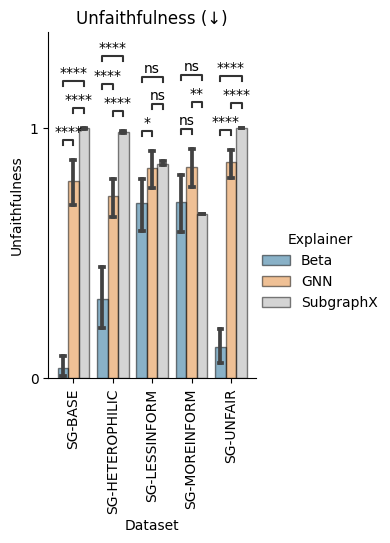

In [40]:
x = 'Dataset'
y = 'Unfaithfulness'
hue = 'Explainer'
hue_order = ['Beta','GNN', 'SubgraphX']
order = ['SG-BASE', 'SG-HETEROPHILIC', 'SG-LESSINFORM', 'SG-MOREINFORM',
       'SG-UNFAIR']
args = dict(x=x, y=y, data=df_xai, hue=hue, hue_order=hue_order, order=order)
g = sns.catplot(edgecolor="black", 
                capsize = 0.1, height=4, 
                aspect=.7,alpha=0.5, kind="bar",
                **args
               ).set(title='Unfaithfulness (↓)').set_xticklabels(rotation=90)
pairs = [
    (("SG-BASE", "Beta"), ("SG-BASE", "GNN")),
    (("SG-BASE", "Beta"), ("SG-BASE", "SubgraphX")),
    (("SG-BASE", "GNN"), ("SG-BASE", "SubgraphX")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "GNN")),
    (("SG-HETEROPHILIC", "Beta"), ("SG-HETEROPHILIC", "SubgraphX")),
    (("SG-HETEROPHILIC", "GNN"), ("SG-HETEROPHILIC", "SubgraphX")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "GNN")),
    (("SG-LESSINFORM", "Beta"), ("SG-LESSINFORM", "SubgraphX")),
    (("SG-LESSINFORM", "GNN"), ("SG-LESSINFORM", "SubgraphX")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "GNN")),
    (("SG-MOREINFORM", "Beta"), ("SG-MOREINFORM", "SubgraphX")),
    (("SG-MOREINFORM", "GNN"), ("SG-MOREINFORM", "SubgraphX")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "GNN")),
    (("SG-UNFAIR", "Beta"), ("SG-UNFAIR", "SubgraphX")),
    (("SG-UNFAIR", "GNN"), ("SG-UNFAIR", "SubgraphX")),
]
for ax_n in g.axes:
    for ax in ax_n:
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 1], [0, 1]) 
        annot = Annotator(ax, pairs, **args)
        annot.configure(test='Mann-Whitney', loc='inside', verbose=2)
        annot.apply_test().annotate()
plt.savefig("Vis/xAIUnfaith.png", bbox_inches='tight')